## Importing stuff I need

In [1]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2

from pixell import enmap,utils,reproject,enplot
from pixell.reproject import healpix2map,thumbnails
from pixell.curvedsky import alm2map

import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
from healpy.fitsfunc import read_alm,read_map

## Reading the files

In [2]:
# simulated maps file location
alm_filename = "lensed_alm.fits"

# lensing convergence file
kap_filename = "kap.fits"

# sz map
tsz_filename = "ksz.fits"

alm_hp = read_alm(alm_filename)
kap_hp = read_map(kap_filename)
tsz_hp = read_map(tsz_filename)

print(alm_hp.dtype, kap_hp.dtype, tsz_hp.dtype)
print(len(alm_hp), len(kap_hp), len(tsz_hp))

complex128 >f4 >f4
34043626 201326592 201326592


## Converting to pixel maps (equatorial CAR)

In [3]:
# 0.5 (1 for now) arcmin resolution car geometry
shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(1.0 / 60.))
# doesn't work on jupyter notebook for some reason?
kap_px = healpix2map(kap_hp.astype(np.float32), shape=shape, wcs=wcs)
tsz_px = healpix2map(tsz_hp.astype(np.float32), shape=shape, wcs=wcs)

In [4]:
# empty CAR map
omap = enmap.empty(shape, wcs, dtype=np.float32)
# killed python? how to deal with this
alm_px = alm2map(alm_hp, omap)

## Visualizing maps

(10801, 21600)
(10801, 21600)


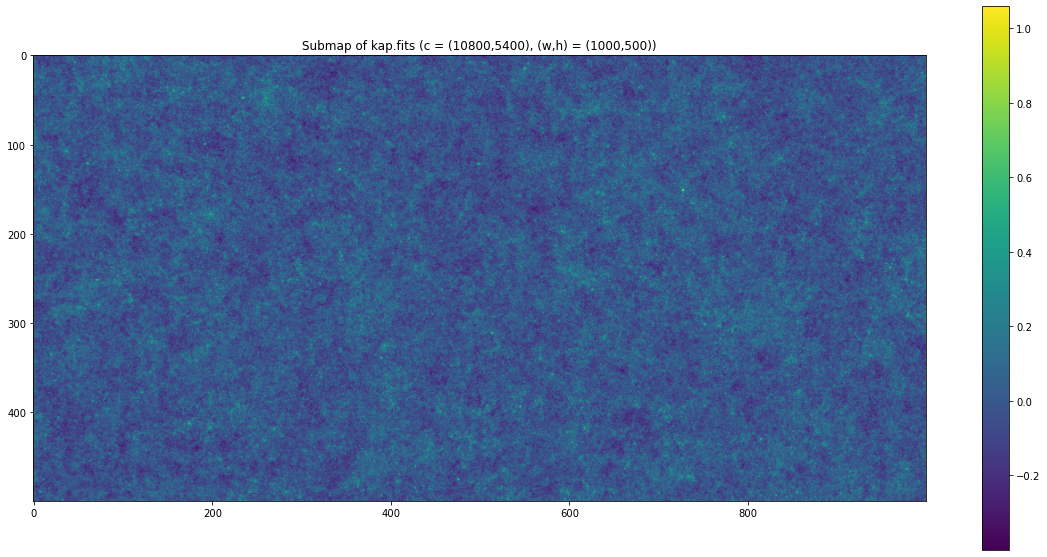

In [5]:
print(kap_px.shape)
print(alm_px.shape)

(ydim, xdim) = kap_px.shape

COLOR_EXTREME = 1.0
yc, xc = ydim // 2, xdim // 2
width = 1000
# based on aspect ratio of map
height = int(width * ydim / xdim)

top, bottom = yc - height//2, yc + height//2
left, right = xc - width//2, xc + width//2

# why does this kill jupyter?
#kap_sub = kap_px.submap([[top, left],
#                        [bottom, right]])

kap_sub = kap_px[top:bottom, left:right]

plt.figure(figsize = (20, 10))
plt.title("Submap of kap.fits (c = (%d,%d), (w,h) = (%d,%d))" \
           % (xc, yc, width, height))
plt.imshow(kap_sub, vmin=COLOR_EXTREME * kap_sub.min(),
                    vmax=COLOR_EXTREME * kap_sub.max())
plt.colorbar()
plt.savefig("kap-submap.png")

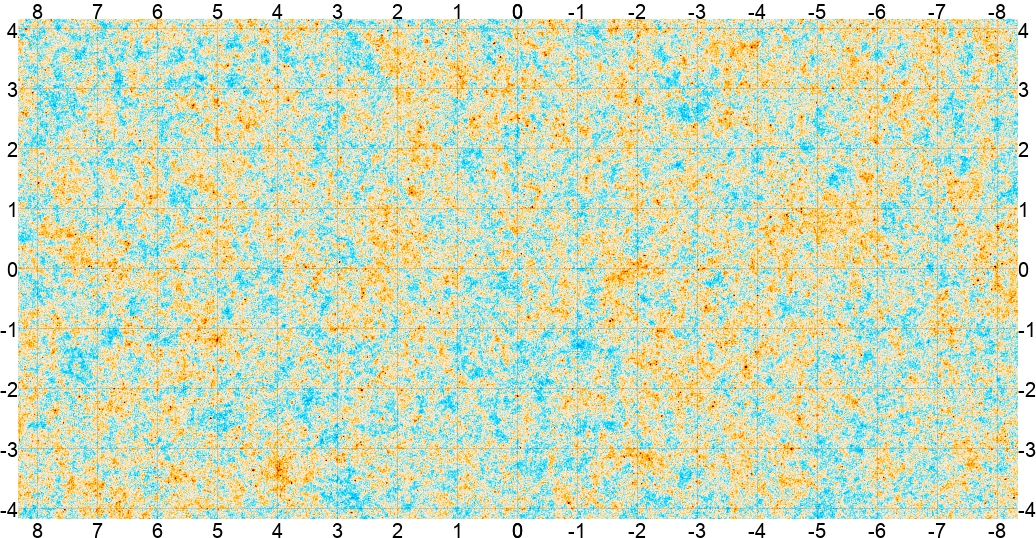

In [6]:
en_plot = enplot.plot(kap_sub, range=0.4 * COLOR_EXTREME * (kap_sub.max() - kap_sub.min()))
#en_plot_colorbar, _ = enplot.draw_colorbar(crange, )

enplot.show(en_plot)
enplot.write("kap-fits-enplot", en_plot)


## Read and Parse Halo Catalog

In [7]:
# should I use the full data file?
f = open("halos_10x10.pksc")

# number of halos?
Nhalo = np.fromfile(f, count=3, dtype=np.int32)[0]

# halo data (10 cols):
# x, y, z [Mpc], vx, vy, vz [km/s], M [M_sun], x_lag, y_lag, z_lag
data = np.fromfile(f, dtype=np.float32)

print("Nhalo: ", Nhalo)
# reshape into 2d array
data_table = np.reshape(data, (Nhalo, 10))
print("first row: ", data_table[0])

x, y, z = data_table[:, 0], data_table[:, 1], data_table[:, 2]
# convert to ra / dec (radians?) from readhalos.py
colat, ra = hp.vec2ang(np.column_stack((x, y, z)))
# convert colat to dec
dec = np.pi/2 - colat



Nhalo:  2079516
first row:  [ 6.07070508e+03 -3.73886780e+02 -5.19141052e+02 -1.35386414e+02
  1.05809166e+02  4.40175514e+01  6.05698872e+00  6.07264795e+03
 -3.75349945e+02 -5.19474243e+02]


## Stacking on locations of these halos

In [8]:
# let's first try 1000 sets of coordinates
Ncoords = 1000

# random sample instead
# ra_subset, dec_subset = ra[:Ncoords], dec[:Ncoords]
idx_random = np.random.choice(len(ra), Ncoords, replace=False)
coords = np.array([[dec[i], ra[i]] for i in idx_random])

# radius of 2 degrees
thumbs_kap = thumbnails(kap_px, coords, r = np.deg2rad(2.), res=np.deg2rad(1.0 / 60.))
thumbs_tsz = thumbnails(tsz_px, coords, r = np.deg2rad(2.),\
                        res=np.deg2rad(1.0 / 60.))

# verbose prints out i/n ra[i, deg] dec[i, deg], 
# stack
stack_kap = 0
stack_tsz = 0
for i in range(len(thumbs_tsz)):
    stack_kap += thumbs_kap[i]
    stack_tsz += thumbs_tsz[i]

# average
avg_kap = stack_kap / Ncoords
avg_tsz = stack_tsz / Ncoords

## Histogram of RA/Dec

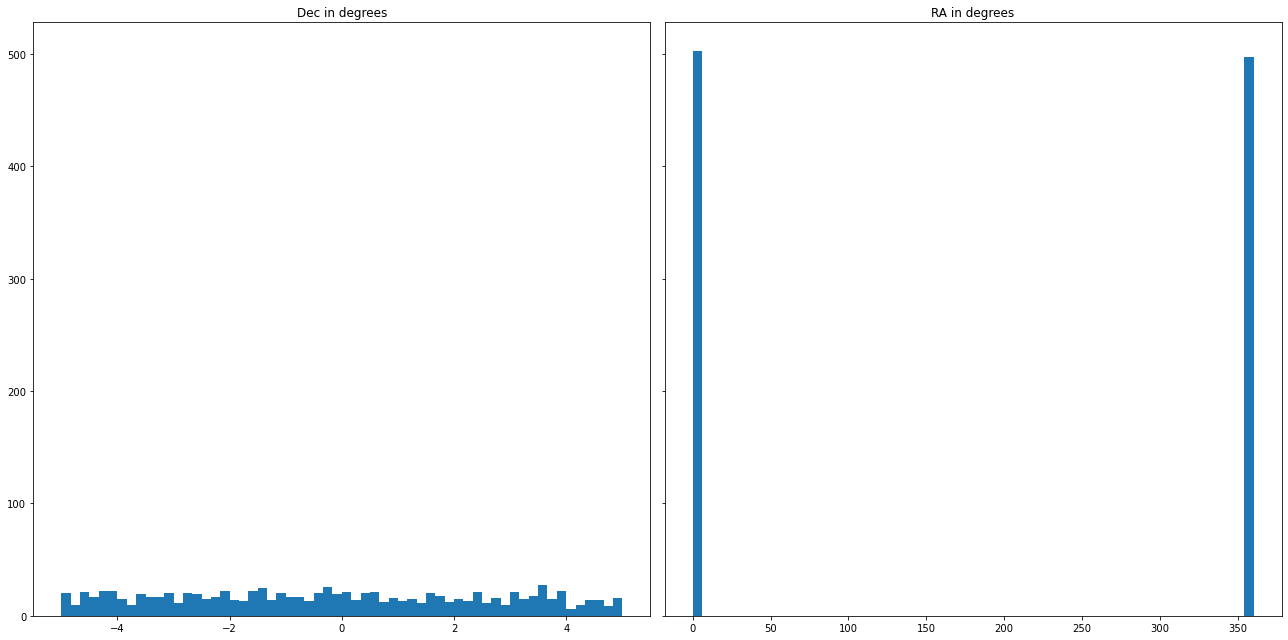

In [17]:
dec_subset = np.rad2deg(coords[:,0])
ra_subset = np.rad2deg(coords[:,1])
N_bins = 60


fig, axs = plt.subplots(1, 2, figsize=(18,9), sharey=True, tight_layout = True)
axs[0].set_title("Dec in degrees")
_ = axs[0].hist(dec_subset, bins=N_bins)
axs[1].set_title("RA in degrees")
_ = axs[1].hist(ra_subset, bins=N_bins)
plt.savefig("dec-ra-hist.png")

## Display result

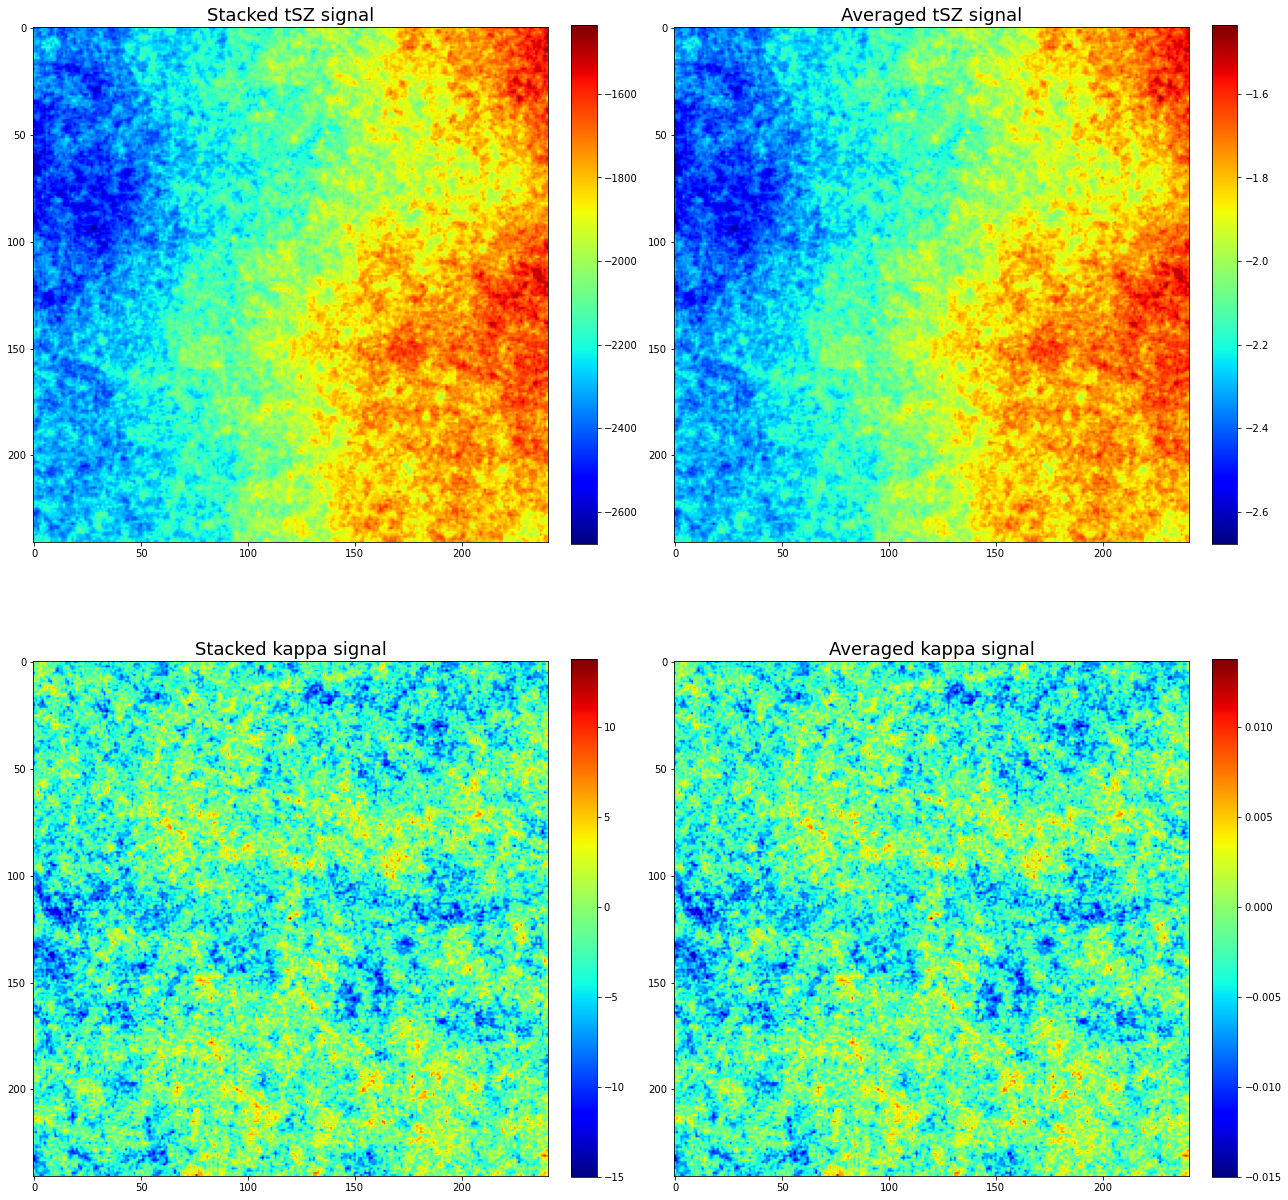

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

im1 = axes[0,0].imshow(stack_tsz, cmap='jet')
axes[0,0].set_title("Stacked tSZ signal", fontsize=18)
im2 = axes[0,1].imshow(avg_tsz, cmap='jet')
axes[0,1].set_title("Averaged tSZ signal", fontsize=18)
im3 = axes[1,0].imshow(stack_kap, cmap='jet')
axes[1,0].set_title("Stacked kappa signal", fontsize=18)
im4 = axes[1,1].imshow(avg_kap, cmap='jet')
axes[1,1].set_title("Averaged kappa signal", fontsize=18)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0,0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[0,1], fraction=0.046, pad=0.04)
fig.colorbar(im3, ax = axes[1,0], fraction=0.046, pad=0.04)
fig.colorbar(im4, ax = axes[1,1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("all-random.png")
plt.show()

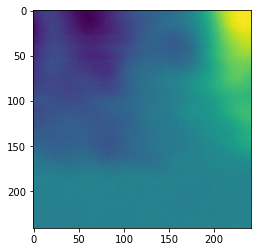

In [11]:
plt.imshow(stack_tsz)
plt.show()

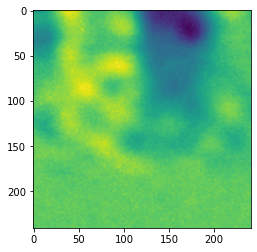

In [9]:
plt.imshow(avg_kap)
plt.savefig("average-kap.png")
plt.show()


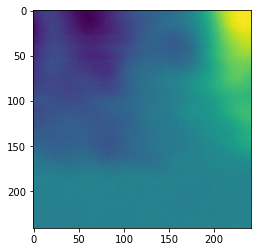

In [10]:
plt.imshow(avg_tsz)
plt.savefig("average-tsz.png")
plt.show()
